In [190]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, ElementNotInteractableException
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ActionChains
from selenium.webdriver.common.actions.wheel_input import ScrollOrigin
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [17]:
def driver_object():
    driver_path = 'D:\Downloads\Code\chromedriver-win64\chromedriver.exe'
    options = webdriver.ChromeOptions()
    #options.add_argument("--headless")
    service = Service(driver_path)
    driver = webdriver.Chrome(service=service, options=options)
    return driver

def cookie_popup(driver):
    try:
        cookies = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, 'SSPGKf')))
        reject_button = WebDriverWait(cookies, 15).until(EC.element_to_be_clickable((By.XPATH, "//button[@jsname='tWT92d']")))
        reject_button.click()
    except Exception as e:
        print("Unable to Bypass Cookies Pop-up:", e)

def get_description(description_panel, driver):
    '''Retrives Job Descriptions \n
        Params: 
        (1) Description panel: Inside the job panel, the other most div for descriptions
        (2) Driver: The driver obj'''
    
    if description_panel.find_element(By.CLASS_NAME, 'CdXzFe'):
        description_click = description_panel.find_element(By.CLASS_NAME, 'CdXzFe')
        ActionChains(driver).click(description_click).perform()
    
    outer_text = description_panel.find_element(By.TAG_NAME, 'span').text
    inner_text = description_panel.find_element(By.TAG_NAME, 'span').text
    description = outer_text + ' ' + inner_text
    return description

def get_salary(job_panel):
    '''Retrives Salary Information (If available, other wise salary is set to 0) \n
        Params: 
        (1) Job_panel: The outer job panel, the other most div for job section'''
    salary = None
    try:
        typical_pay_tag = job_panel.find_element(By.XPATH, './/div[@class="gWhMmc"]//span[@class="IGY5Pe"]')
        salary = typical_pay_tag.text
        
    except NoSuchElementException:
        try:
            salary_tag = job_panel.find_elements(By.XPATH, './/span[@aria-hidden="true"]')
            for salaries in salary_tag:
                salary_text = salaries.text
                if '£' in salary_text:
                    salary = salary_text
                    if  ' a year' in salary_text:
                        salary = salary_text.replace(' a year','')
                    else:
                        salary = salary_text
        except NoSuchElementException:
            salary = 0
        
        if salary is None:
            salary = 0
    return salary

def job_scraper(driver):
    # The up most Div elements for job cards and their respective Dynamic Description Panel
    parent_card_div = driver.find_element(By.CLASS_NAME, 'zxU94d')
    parent_jpanel_div = driver.find_element(By.CLASS_NAME, 'whazf')

    # Initial Number of Job Cards Loaded
    initial_cards = parent_card_div.find_elements(By.CLASS_NAME, 'iFjolb')
    initial_len = len(initial_cards)

    job_list = parent_card_div.find_element(By.CLASS_NAME, 'vWdgBe')
    origin = ScrollOrigin.from_element(job_list)

    scroll = initial_len
    lengths = []
    JobData = []
    clicked_job_cards = set()

    while True:
        '''
        (1) New Job cards are dynamically loaded as the page is scrolled.
        (2) First working with 10 Initial Job cards, than scrolling to load in new cards.
        (3) Finally, appending them to JobData list with relevant Job data & clicking on the cards to retrive application link!
        (4) If no new cards are loaded after reaching the bottom, exiting the loop.
        '''
        #Scrolling Functionality
        time.sleep(1)
        ActionChains(driver).scroll_from_origin(origin, 0, scroll + 20).perform()

        job_cards = job_list.find_elements(By.CLASS_NAME, 'iFjolb')
        current_len = len(job_cards)

        for job in job_cards:
            job_title = job.find_element(By.CLASS_NAME, 'BjJfJf').text
            company_name = job.find_element(By.CLASS_NAME, 'vNEEBe').text
            location_site = job.find_elements(By.CLASS_NAME,'Qk80Jf') 
            location = location_site[0].text
            site = location_site[1].text

            if job in clicked_job_cards:
                continue

            # Clicking Functionality
            ActionChains(driver).click(job).perform()
            job_panel = parent_jpanel_div.find_element(By.CLASS_NAME, 'KGjGe')

            # Getting the First job link 
            job_links = job_panel.find_element(By.CLASS_NAME, 'B8oxKe')
            ancor_tag = job_links.find_element(By.CLASS_NAME, 'pMhGee').get_attribute('href')
            time.sleep(1)
            
            #Get descripion
            description_panel = job_panel.find_element(By.CLASS_NAME, 'YgLbBe')
            try:
                try:
                    description = get_description(description_panel, driver)
                except ElementNotInteractableException:
                    continue
            except NoSuchElementException:
                continue

            #Get Salary
            time.sleep(3)
            salary = get_salary(job_panel)
            
            JobData.append([job_title, company_name, salary, location, site, ancor_tag, description])
            clicked_job_cards.add(job)
        
        if current_len >= scroll:
            scroll = current_len
            lengths.append(current_len)
            # Checking against previous iterations to ensure no new cards are loaded
            if len(lengths) > 5:
                lengths.pop(0)
                if all(length == lengths[0] for length in lengths):
                    print('  No new cards for the last several iterations')
                    break
        # Safety else
        else:
            print('  No new cards')
            break

    return JobData
def remove_duplicates(data):
    # Since we do not care about the order of the jobs 'set' is used to identify duplicates and remove them.
    unique_jobs = set(tuple(job) for job in data)
    unique_job_list = [list(job) for job in unique_jobs]
    print('Total Jobs after removing duplicates:',len(unique_job_list))
    return unique_job_list
        

In [18]:
roles = ['machine+learning','graduate+data+science','graduate+software+engineering',
         'data+science']
url = "https://www.google.com/search?q={}&ibp=htl;jobs&=#htivrt=jobs"

Jobs = []
start = time.time()
driver = driver_object()
for index, r in enumerate(roles, start=1):
    keyword = url.format(r)
    print(f"\nCurrently scraping jobs {index} of {len(roles)}, role: {r.replace('+', ' ')}")
    print('Current Url: ',keyword)
    driver.get(keyword)

    cookie_element = None
    try:
        cookie_element = driver.find_element(By.CLASS_NAME, 'SSPGKf')
    except:
        pass
    if cookie_element:
        cookie_popup(driver)
    
    scrapped_data = job_scraper(driver=driver)
    print('  Jobs found for this role:', len(scrapped_data))
    Jobs.extend(scrapped_data)
    print('  Total number of jobs scraped:', len(Jobs))
    time.sleep(10)

driver.quit()
end = time.time()
print('Finished, All jobs found:',len(Jobs))
print('Overall time taken: %.2f' % ((end - start) / 60), 'minutes')

# Removing duplicates and save to Data frame / CSV
cleaned_jobs = remove_duplicates(Jobs)
df = pd.DataFrame(data=cleaned_jobs, columns=['Job Title', 'Company Name', 'Salary', 'Location',
                                               'Partner Site', 'URL', 'Description'])

df.to_csv('Jobs_scrapped.csv')




Currently scraping jobs 1 of 4, role: machine learning
Current Url:  https://www.google.com/search?q=machine+learning&ibp=htl;jobs&=#htivrt=jobs
  No new cards for the last several iterations
  Jobs found for this role: 142
  Total number of jobs scraped: 142

Currently scraping jobs 2 of 4, role: graduate data science
Current Url:  https://www.google.com/search?q=graduate+data+science&ibp=htl;jobs&=#htivrt=jobs
  No new cards for the last several iterations
  Jobs found for this role: 138
  Total number of jobs scraped: 280

Currently scraping jobs 3 of 4, role: graduate software engineering
Current Url:  https://www.google.com/search?q=graduate+software+engineering&ibp=htl;jobs&=#htivrt=jobs
  No new cards for the last several iterations
  Jobs found for this role: 138
  Total number of jobs scraped: 418

Currently scraping jobs 4 of 4, role: data science
Current Url:  https://www.google.com/search?q=data+science&ibp=htl;jobs&=#htivrt=jobs
  No new cards for the last several iterati

In [20]:
df

,Job Title,Company Name,Salary,Location,Partner Site,URL,Description
0,Operational Data Scientist,Secret Intelligence Service,"£55,788–£59,297",London,via Indeed,https://uk.indeed.com/viewjob?jk=6ae371badc9b0...,"Department : IT, Science & Technical\n\nLocati..."
1,"Graduate Software Engineer, Modelling",Runna,£33k–49k,London,via Monster.co.uk,https://www.monster.co.uk/job-openings/graduat...,We're putting together a talented team to buil...
2,Software Engineer Internship London,Citadel,£25k–51k,London,via Bright Network,https://www.brightnetwork.co.uk/graduate-jobs/...,Our engineers work in small teams to turn the ...
3,Senior Data Engineer,ADLIB Recruitment,£65k–100k,London,via ADLIB Recruitment,https://www.adlib-recruitment.co.uk/sector/mac...,Senior Data Engineer - Join a Pioneering Data ...
4,Data Scientist,Abtrace,£45k–80k,Anywhere,via Jobs By Workable,https://apply.workable.com/abtrace/j/5DDA18DF0...,The Company\n\nAbtrace is a health tech compan...
...,...,...,...,...,...,...,...
525,Graduate Data Analyst,IO Associates,£24k–26k,London,via IO Associates,https://www.ioassociates.co.uk/job/graduate-da...,"Graduate Data Analyst | Hybrid | £24,000 + 20%..."
526,Graduate Software Developer,City Science,0,England,via Monster.co.uk,https://www.monster.co.uk/job-openings/graduat...,Location: Remote (all UK locations considered)...
527,Machine Learning Engineer - Remote,OHO,US$100k–130k,London,via OHO Group,https://www.oho.co.uk/job-details/?id=machine-...,Machine Learning Engineer - Top Software Compa...
528,Data Scientist,Jellyfish,£45k–80k,London,via App.otta.com,https://app.otta.com/jobs/boCUIcNR?utm_campaig...,Requirements\n• Desire to help people use data...


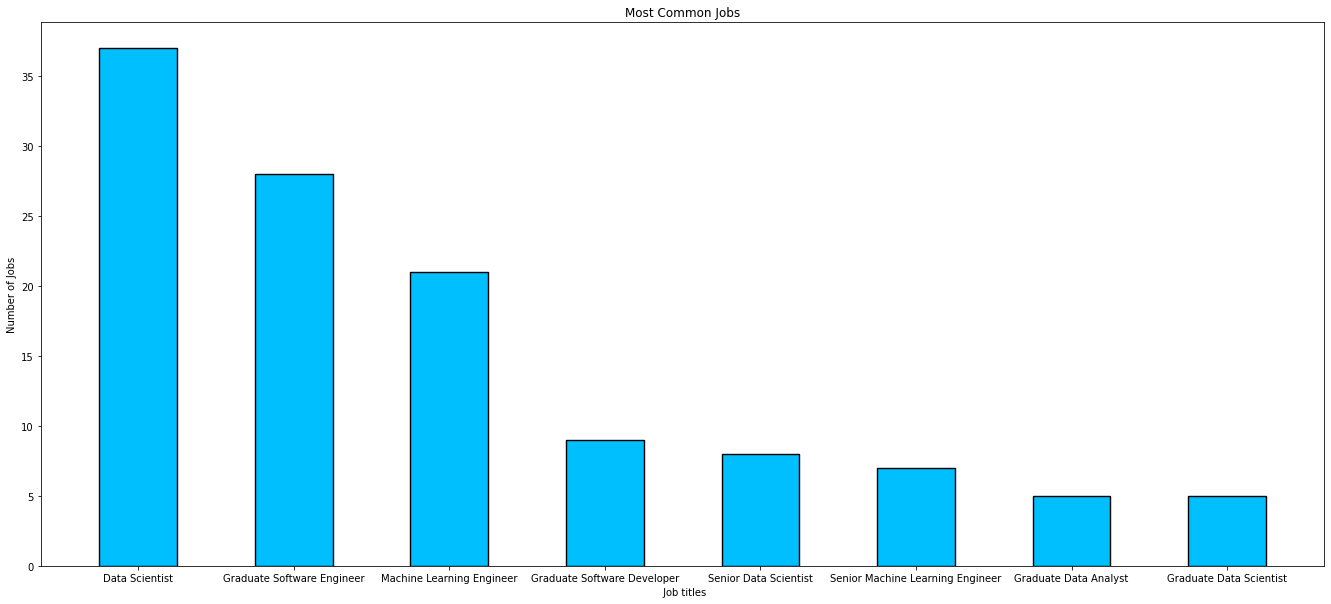

In [65]:
job_count = df['Job Title'].value_counts()
top_jobs = job_count.head(8)

plt.figure(figsize=(23,10))
plt.bar(top_jobs.index,top_jobs.values, width=0.5, color='deepskyblue', edgecolor='black', linewidth=1.4)
plt.xlabel(' Job titles')
plt.ylabel('Number of Jobs')
plt.title('Most Common Jobs')
plt.show()

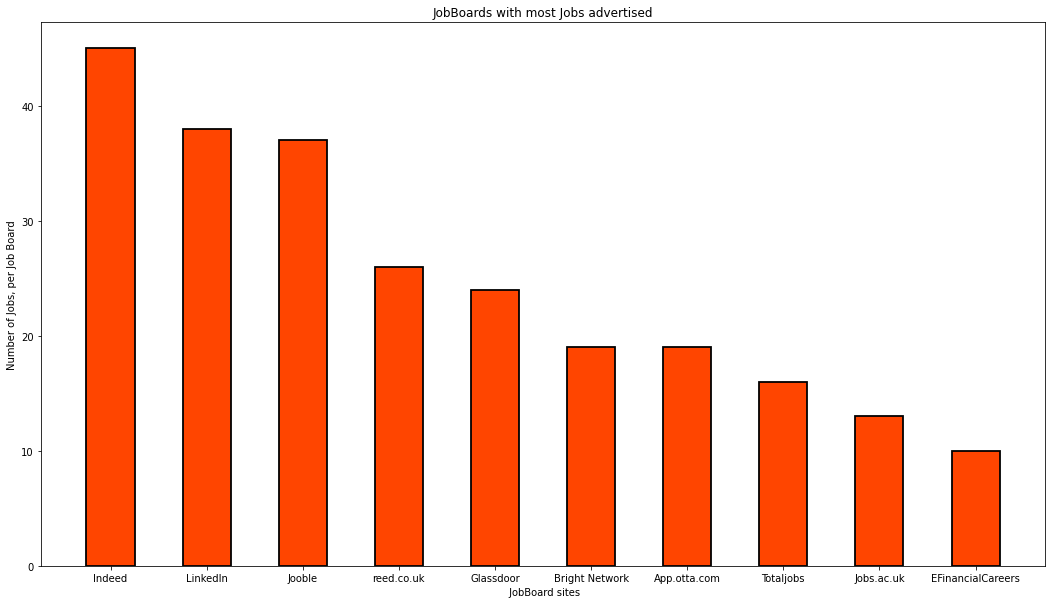

In [72]:
jobboard_count = df['Partner Site'].str.replace('via ', '').value_counts()
top_sites = jobboard_count.head(10)

plt.figure(figsize=(18,10))
plt.bar(top_sites.index,top_sites.values, width=0.5, color='orangered', edgecolor='black', linewidth=1.8)
plt.xlabel(' JobBoard sites')
plt.ylabel('Number of Jobs, per Job Board')
plt.title('JobBoards with most Jobs advertised')
plt.show()

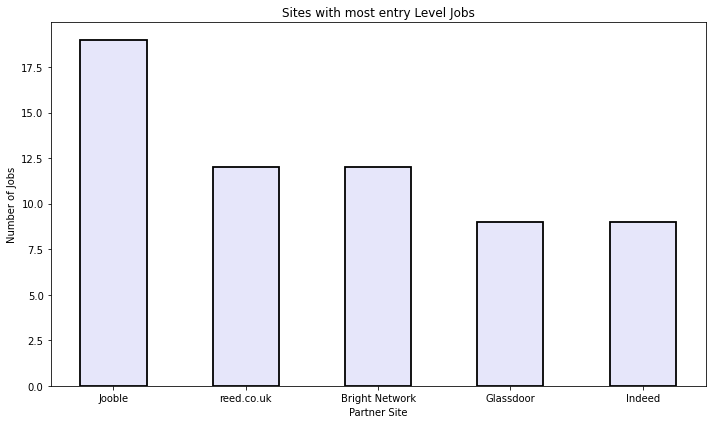

In [90]:
graduate_keywords = ['Graduate', 'Entry Level', 'Junior', 'Recent Graduate','Grad']
graduate_df = df[df['Job Title'].str.contains('|'.join(graduate_keywords), case=False, na=False)]
graduate_counts = graduate_df['Partner Site'].str.replace('via ','').value_counts()
top_grad_sites = graduate_counts.head(5)

plt.figure(figsize=(10, 6))
plt.bar(top_grad_sites.index, top_grad_sites.values, width=0.5, color='lavender',edgecolor='black', linewidth=1.8)
plt.title('Sites with most entry Level Jobs')
plt.xlabel('Partner Site')
plt.ylabel('Number of Jobs')
plt.tight_layout()

plt.show()

In [88]:
graduate_df.head(5)

,Job Title,Company Name,Salary,Location,Partner Site,URL,Description
1,"Graduate Software Engineer, Modelling",Runna,£33k–49k,London,via Monster.co.uk,https://www.monster.co.uk/job-openings/graduat...,We're putting together a talented team to buil...
7,Graduate Data Scientist,Grayce,£25k–58k,Cambridge,via Jobs By Workable,https://apply.workable.com/grayce/j/F0471B86A4...,🌟 Grayce…… Our Mission is Your Success 🌟 \n\nR...
9,Software Engineering Graduate 2024,Quantexa,£33k–49k,London,via WorkinStartups.com,https://workinstartups.com/job-board/job/14078...,R&D Programme 2023\nFounded in 2016 with only ...
10,Graduate Software Engineer / Graduate Software...,Global Music Services Company,£25k,London,via Indeed,https://uk.indeed.com/viewjob?jk=3f2a0dd5a1cca...,Graduate Software Engineer / Graduate Software...
11,Graduate Software Engineer,Hunter Bond,£33k–49k,London,via Jooble,https://uk.jooble.org/jdp/2720986145292950987?...,An Elite High Frequency Trading Firm are looki...


In [184]:
salaries_df = df.copy()

In [185]:
salaries_df['Salary'] = salaries_df['Salary'].str.replace('US\$', '').str.replace('£', '').str.replace('k','000').str.replace('K','000').str.replace(',','')

C:\Users\MrJoker\AppData\Local\Temp\ipykernel_36056\1756856930.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  salaries_df['Salary'] = salaries_df['Salary'].str.replace('US\$', '').str.replace('£', '').str.replace('k','000').str.replace('K','000').str.replace(',','')


In [187]:
salaries_df['Salary'] = salaries_df['Salary'].astype(str).str.replace('[^\d–]+', '', regex=True).str.replace('K', '000')
def calculate_average_salary(salary_range):
    # Check if the salary is a range
    if '–' in salary_range:
        lower, upper = map(float, salary_range.split('–'))
        return (lower + upper) / 2
    else:
        # Handle cases where there is no range (e.g., single salaries or non-numeric values)
        try:
            return float(salary_range)
        except ValueError:
            return np.nan
salaries_df['Average Salary'] = salaries_df['Salary'].apply(calculate_average_salary)

In [189]:
salaries_df['Average Salary'].isna().sum()

161

<Figure size 1152x648 with 0 Axes>

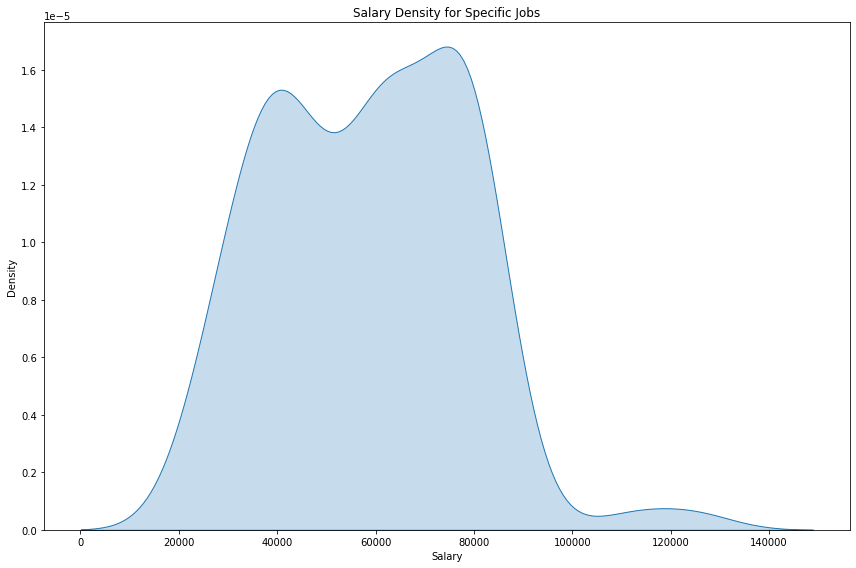

In [212]:
specific_titles = ['Graduate Data Scientist', 'Machine Learning Engineer', 'Machine Learning', 'Graduate Software Engineer', 'Data Scientist', 'Software Developer', 
                   'Data Analyst', 'Lead Software Developer', 'Senior Machine Learning Engineer', 'Senior Software Engineer', 'Senior Data Scientist', 'Research Engineer']
cleaned_df = salaries_df.dropna(subset=['Average Salary'])
filtered_df = cleaned_df[cleaned_df['Job Title'].isin(specific_titles)]
# Plot a density plot for each job title
plt.figure(figsize=(16, 9))
plt.figure(figsize=(12, 8))
sns.kdeplot(data=filtered_df['Average Salary'], fill=True)

# Add labels and title
plt.xlabel('Salary')
plt.ylabel('Density')
plt.title('Salary Density for Specific Jobs')

# Show the plot
plt.tight_layout()
plt.show()

In [211]:
df.head(50)

,Job Title,Company Name,Salary,Location,Partner Site,URL,Description
0,Operational Data Scientist,Secret Intelligence Service,"£55,788–£59,297",London,via Indeed,https://uk.indeed.com/viewjob?jk=6ae371badc9b0...,"Department : IT, Science & Technical\n\nLocati..."
1,"Graduate Software Engineer, Modelling",Runna,£33k–49k,London,via Monster.co.uk,https://www.monster.co.uk/job-openings/graduat...,We're putting together a talented team to buil...
2,Software Engineer Internship London,Citadel,£25k–51k,London,via Bright Network,https://www.brightnetwork.co.uk/graduate-jobs/...,Our engineers work in small teams to turn the ...
3,Senior Data Engineer,ADLIB Recruitment,£65k–100k,London,via ADLIB Recruitment,https://www.adlib-recruitment.co.uk/sector/mac...,Senior Data Engineer - Join a Pioneering Data ...
4,Data Scientist,Abtrace,£45k–80k,Anywhere,via Jobs By Workable,https://apply.workable.com/abtrace/j/5DDA18DF0...,The Company\n\nAbtrace is a health tech compan...
5,Head of Data Science,Wyatt Partners,£150K–£180K,London,via Indeed,https://uk.indeed.com/viewjob?jk=0087a2c0df010...,Head of Data Science is required by a FTSE 100...
6,Data Scientist,Akkodis,£38K–£44K,England,via Jooble,https://uk.jooble.org/jdp/-151685845716044231?...,Lead Data Scientist/ Data Scientist/ Senior Re...
7,Graduate Data Scientist,Grayce,£25k–58k,Cambridge,via Jobs By Workable,https://apply.workable.com/grayce/j/F0471B86A4...,🌟 Grayce…… Our Mission is Your Success 🌟 \n\nR...
8,Lead Software Developer,MBDA Careers,£43k–69k,Stevenage,via MBDA Careers,https://www.mbdacareers.co.uk/job/lead-softwar...,MBDA is a leading defence organisation. We are...
9,Software Engineering Graduate 2024,Quantexa,£33k–49k,London,via WorkinStartups.com,https://workinstartups.com/job-board/job/14078...,R&D Programme 2023\nFounded in 2016 with only ...
